# Auto CHARGE Predictions Using Keras

In [4]:
!rm -rf ActuarialThesis
!git clone https://github.com/aderdouri/ActuarialThesis.git
%ls -ltr ActuarialThesis

Cloning into 'ActuarialThesis'...
remote: Enumerating objects: 1089, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (260/260), done.
remote: Total 1089 (delta 203), reused 228 (delta 110), pack-reused 717
Receiving objects: 100% (1089/1089), 131.35 MiB | 23.17 MiB/s, done.
Resolving deltas: 100% (493/493), done.
total 24
drwxr-xr-x 2 root root 4096 Nov 12 19:27 Data/
drwxr-xr-x 2 root root 4096 Nov 12 19:27 EMTboost/
drwxr-xr-x 5 root root 4096 Nov 12 19:27 Notebooks/
drwxr-xr-x 2 root root 4096 Nov 12 19:27 R/
drwxr-xr-x 2 root root 4096 Nov 12 19:27 src/
-rw-r--r-- 1 root root   54 Nov 12 19:27 README.md


In [5]:
!mkdir ActuarialThesis/plots_rgr
!ls -ltr ActuarialThesis/plots_rgr

total 0


In [ ]:
# Ajouter le répértoire src
import sys
sys.path.insert(0,'./ActuarialThesis/src/')

In [ ]:
import installHelper

In [ ]:
# Installer les packages nécéssaires
%time installHelper.installALL()

CPU times: user 415 ms, sys: 57 ms, total: 472 ms
Wall time: 1min 57s


In [ ]:
# On doit trouver tous les packages mentionés dans le grep
!pip list -v | grep -e catboost -e 'imbalanced-learn' -e 'optuna' -e 'catboost' -e 'lime' -e 'shap'

catboost                         1.2.2                 /usr/local/lib/python3.10/dist-packages pip
imbalanced-learn                 0.10.1                /usr/local/lib/python3.10/dist-packages pip
lime                             0.2.0.1               /usr/local/lib/python3.10/dist-packages pip
optuna                           3.4.0                 /usr/local/lib/python3.10/dist-packages pip
shap                             0.43.0                /usr/local/lib/python3.10/dist-packages pip
shapely                          2.0.2                 /usr/local/lib/python3.10/dist-packages pip


In [ ]:
# Importer les packages nécéssaires
from helper import *

In [ ]:
# Appliquer le theme par défaut
sns.set_theme()

In [ ]:
#!pip install scikit-plot

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 2.9 MB/s eta 0:00:00


In [ ]:
from sklearn.ensemble import IsolationForest # Outlier Detection
from keras.models import Sequential # Sequential Neural Network
from keras.layers import Dense
from keras.callbacks import EarlyStopping # Early Stopping Callback
from keras.backend import mean
from keras.optimizers import Adam # Optimizer
from keras_tuner.tuners import RandomSearch, Hyperband # HyperParameter Tuning
import warnings
warnings.filterwarnings('ignore') # To ignore warnings.

In [ ]:
# Partir du dataset déja encodé et splité en Train/Test
df_train = pd.read_csv('ActuarialThesis/Data/encodedTrainBASEAUTO.csv')
df_test = pd.read_csv('ActuarialThesis/Data/encodedTestBASEAUTO.csv')
df_train.head()

,ACV,SEX,STATUT,AGECOND,K8000,RM,CAR_AUTRE,CAR_BER,CAR_BRK,CAR_CTE,...,SEGM_M2,GARAGE_1,GARAGE_2,GARAGE_3,CSP_1,CSP_50,CSP_55,CSP_60,CSP_AUTRE,CHARGE
0,-0.551995,1,0,2.524444,1,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.000000
1,-1.114303,0,0,0.762290,0,-0.817279,0.0,1.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.000000
2,0.853775,0,1,-1.067640,0,0.732469,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,2154.048943
3,-1.114303,0,0,-0.864314,0,-0.817279,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.000000
4,-1.395457,0,0,-1.067640,0,-0.300697,0.0,0.0,1.0,0.0,...,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,772.435649


## Loading the Dataset

In [ ]:
#clf = IsolationForest(max_samples = 100, random_state = 42)
#clf.fit(df_train)
#y_noano = clf.predict(df_train)
#y_noano = pd.DataFrame(y_noano, columns = ['Top'])
#y_noano[y_noano['Top'] == 1].index.values

#df_train_ano = df_train.iloc[y_noano[y_noano['Top'] == -1].index.values]

#df_train = df_train.iloc[y_noano[y_noano['Top'] == 1].index.values]
#df_train.reset_index(drop = True, inplace = True)
#print("Number of Outliers:", y_noano[y_noano['Top'] == -1].shape[0])
#print("Number of rows without outliers:", df_train.shape[0])

Number of Outliers: 170
Number of rows without outliers: 7756


In [ ]:
X_train = df_train.drop('CHARGE', axis=1)
y_train = df_train['CHARGE']

X_test = df_test.drop('CHARGE', axis=1)
y_test = df_test['CHARGE']

# Split the train set into Train/Val sets: 80:20
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=13)

## MODELLING

### We would use Random Search Algorithm from Keras for hyper-parameter tuning of the model.

In [1]:
import tensorflow as tf
def tweedie_loss_func(p):
  def tweedie_loglikelihood(y_true, y_pred):
    loss = - y_true * tf.pow(y_pred, 1 - p) / (1 - p) + tf.pow(y_pred, 2 - p) / (2 - p)
    return tf.reduce_mean(loss)
  return tweedie_loglikelihood

In [2]:
tweedie_loss = tweedie_loss_func(1.5)

In [ ]:
def model_builder(hp):
    model = Sequential()
    for i in range(hp.Int('layers', 2, 10)):
        model.add(Dense(units=hp.Int('units_' + str(i),
                                            min_value=32,
                                            max_value=512,
                                            step=32),
                               activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4])),
                  loss='mse',
                  metrics=['mse']
                  )
    return model

In [ ]:
tuner_random_search = RandomSearch(
    model_builder,
    objective='val_mse',
    max_trials=10,
    executions_per_trial=3,
    directory='model_dir',
    project_name='AutoClaims_Prediction',
    overwrite=True
    )

tuner_random_search.search(X_train, y_train,
              batch_size=128,
              epochs=50,
              validation_data=(X_val, y_val)
              )


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
9                 |9                 |layers
512               |512               |units_0
192               |192               |units_1
0.0001            |0.0001            |learning_rate

Epoch 1/50
53/53 [==============================] - 2s 11ms/step - loss: nan - tweedie_loglikelihood: nan - val_loss: nan - val_tweedie_loglikelihood: nan
Epoch 2/50
53/53 [==============================] - 0s 6ms/step - loss: nan - tweedie_loglikelihood: nan - val_loss: nan - val_tweedie_loglikelihood: nan
Epoch 3/50
53/53 [==============================] - 0s 6ms/step - loss: nan - tweedie_loglikelihood: nan - val_loss: nan - val_tweedie_loglikelihood: nan
Epoch 4/50
53/53 [==============================] - 0s 6ms/step - loss: nan - tweedie_loglikelihood: nan - val_loss: nan - val_tweedie_loglikelihood: nan
Epoch 5/50
53/53 [==============================] - 0s 7ms/step - loss: nan - tweedie_loglikelihood: nan - val_lo

KeyboardInterrupt: ignored

In [ ]:
# Get the optimal hyperparameters
best_hps=tuner_random_search.get_best_hyperparameters(num_trials=1)[0]
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner_random_search.hypermodel.build(best_hps)

In [ ]:
early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=128,
                    epochs=100,
                    callbacks=[early_stop])

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_7 (Dense)             (None, 96)                7008      
                                                                 
 dense_8 (Dense)             (None, 352)               34144     
                                                                 
 dense_9 (Dense)             (None, 1)                 353       
                                                                 
Total params: 41505 (162.13 KB)
Trainable params: 41505 (162.13 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


<Axes: >

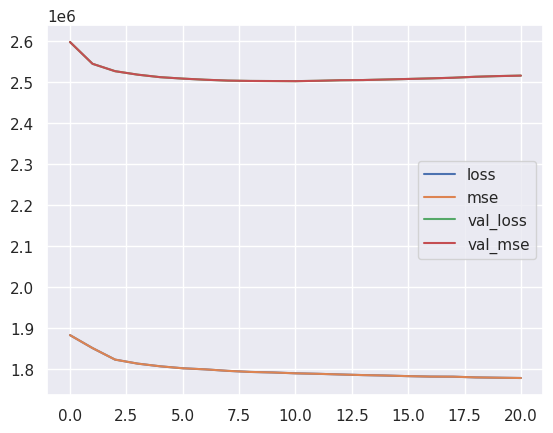

In [ ]:
losses = pd.DataFrame(model.history.history)
losses.plot()

In [3]:
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=Adam(learning_rate=0.001), loss = 'mse')
    return model
model = create_model()
model.summary()


early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=128,
                    epochs=1000,
                    callbacks=[early_stop])

NameError: ignored

In [ ]:
# Mean squared logarithmic error (MSLE)
from sklearn.metrics import mean_squared_log_error
y_test = df_test['CHARGE']
y_pred = model.predict(X_test).reshape(-1)

66/66 [==============================] - 0s 2ms/step


In [ ]:
print('MSLE score:')
print('\tDeepLearning loss\t', mean_squared_log_error(y_test, y_pred))

MSLE score:
	DeepLearning loss	 22.86024369359416


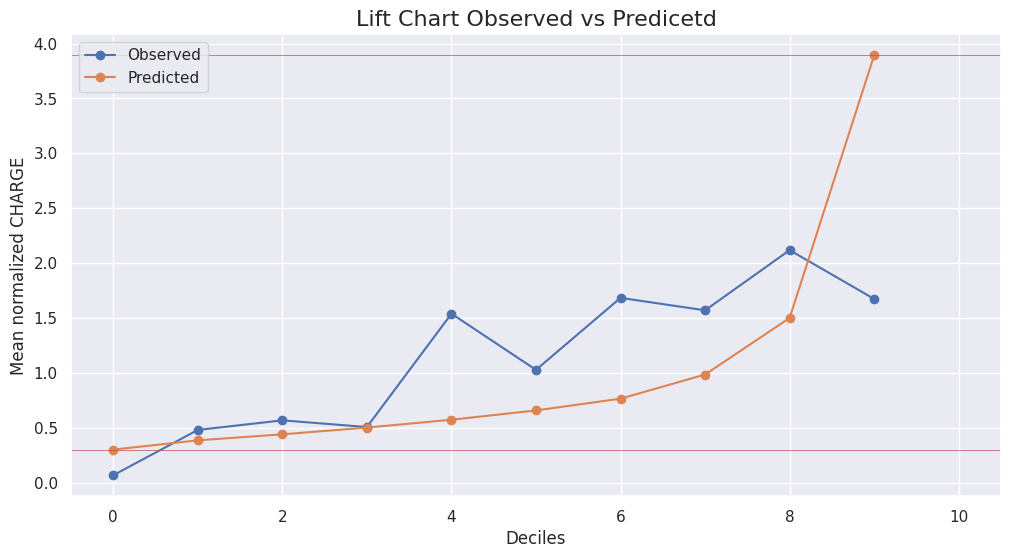

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred)
fig, ax = plotLiftChart(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLiftChart.pdf')

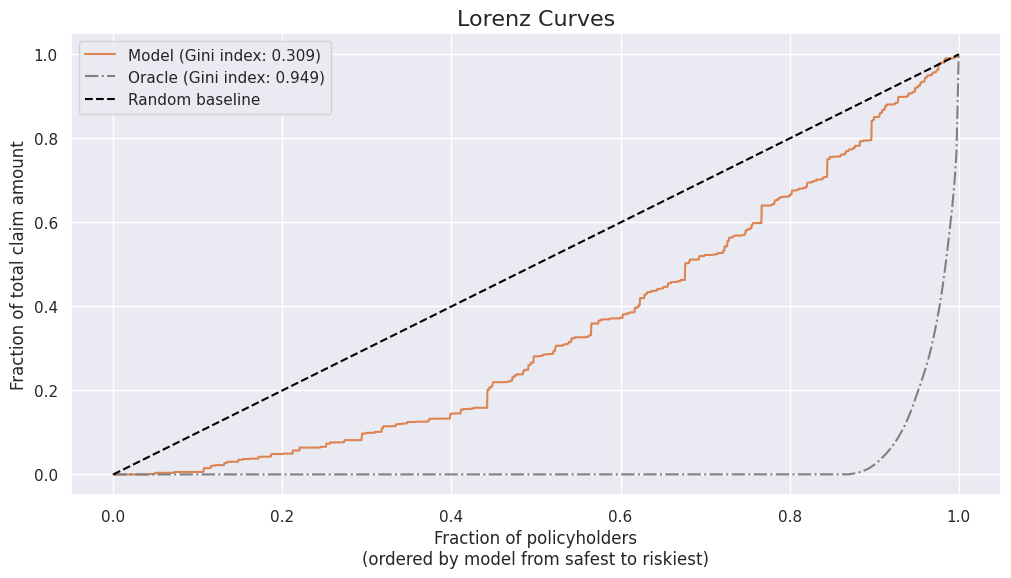

In [ ]:
df_ObsVsPred = df_ObservedVsPredicted(y_test, y_pred)
fig, ax = plotLorenzCurve(df_ObsVsPred)
fig.savefig('./ActuarialThesis/plots_rgr/myCatBoostRegressorLorenzCurve.pdf')

In [ ]:
def wrapper(param1):
  def custom_loss_1(y_true, y_pred):
    diff = math_ops.squared_difference(y_pred, y_true)  #squared difference
    loss = mean(diff, axis=-1) #mean
    loss = loss / param1
    return loss
  return custom_loss_1

In [ ]:
from tensorflow.python.ops import math_ops
loss = wrapper(10.0)
final_loss = loss(y_true=[[10.0,7.0]], y_pred=[[8.0, 6.0]])
print(f"Final Loss is {final_loss.numpy()}")

Final Loss is [0.25]


In [ ]:
import tensorflow as tf
def tweedie_loss_func(p):
  def tweedie_loglikelihood(y_true, y_pred):
    loss = - y_true * tf.pow(y_pred, 1 - p) / (1 - p) + tf.pow(y_pred, 2 - p) / (2 - p)
    return tf.reduce_mean(loss)
  return tweedie_loglikelihood

In [ ]:
tweedie_loss = tweedie_loss_func(1.5)
final_loss = tweedie_loss(np.array([10.0, 7.0]), np.array([8.0, 6.0]))
print(f"Final Loss is {final_loss}")

Final Loss is 10.605637937423037


In [ ]:
tweedie_loss = tweedie_loss_func(1.5)
def create_model():
    # create model
    model = Sequential()
    model.add(Dense(32, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(448, activation='relu'))
    model.add(Dense(512, activation='relu'))
    model.add(Dense(384, activation='relu'))
    model.add(Dense(1))
    # Compile model
    model.compile(optimizer=SGD(learning_rate=0.01), loss = tweedie_loss)
    return model
model = create_model()
model.summary()


early_stop = EarlyStopping(monitor='val_loss',
                           mode='min',
                           verbose=1,
                           patience=10)

history = model.fit(X_train, y_train,
                    validation_split=0.2,
                    batch_size=128,
                    epochs=1000
                    #,callbacks=[early_stop]
                    )

NameError: ignored